In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
data_inicial = pd.read_csv('./admission.csv')
data_inicial.head()
for i in data_inicial:
    print(i)

Serial No.
GRE Score
TOEFL Score
University Rating
SOP
LOR 
CGPA
Research
Chance of Admit 


In [7]:
# Comenzar con un poquito de exploración
data_inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
Serial No.           400 non-null int64
GRE Score            400 non-null int64
TOEFL Score          400 non-null int64
University Rating    400 non-null int64
SOP                  400 non-null float64
LOR                  400 non-null float64
CGPA                 400 non-null float64
Research             400 non-null int64
Chance of Admit      400 non-null float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [29]:
no_usar = 'Chance of Admit '
data_continuar = data_inicial.drop(no_usar, 1)
data_continuar.head(1)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1,337,118,4,4.5,4.5,9.65,1


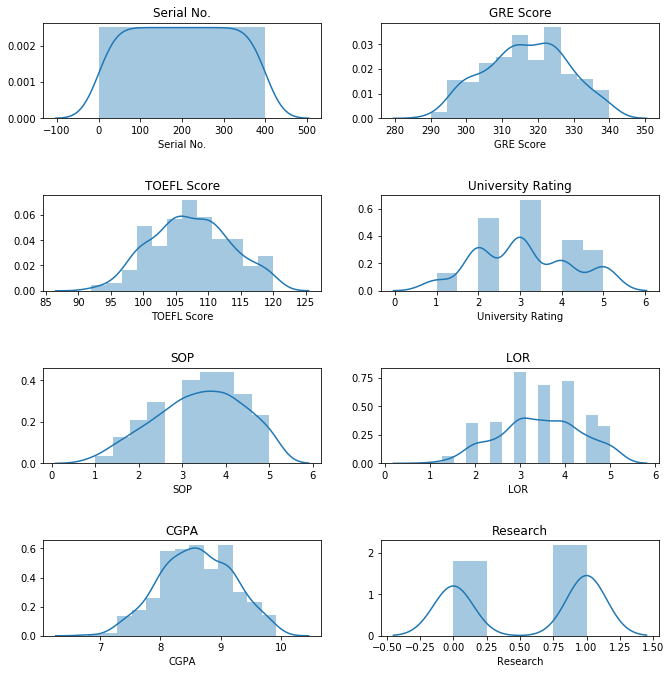

In [32]:
# COLUMNA GRE SCORE 

axis = []

cont = 1
fig = plt.figure(figsize=(10,10))
for i in data_continuar:
    axtemp = fig.add_subplot(4,2,cont)
    fig.tight_layout(pad=3.0)
    sns.distplot(data_continuar[i])
    plt.title(i)
    cont += 1

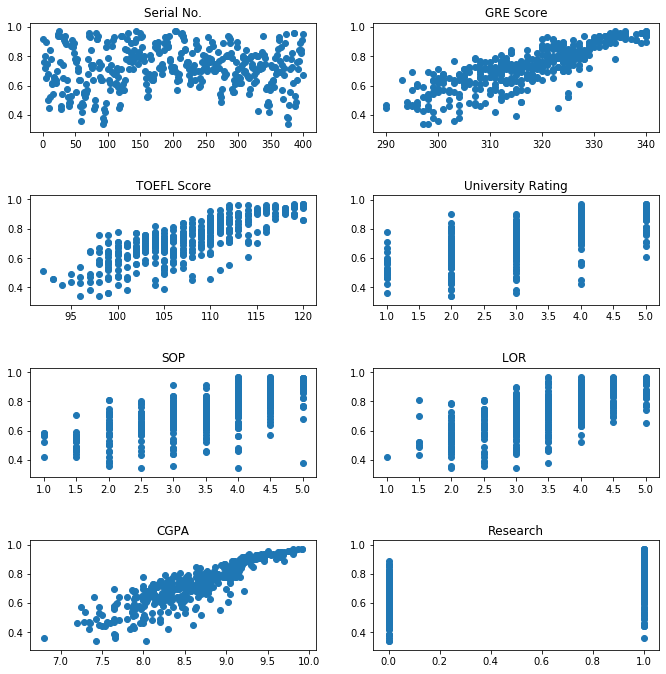

In [33]:
axis = []

cont = 1
fig = plt.figure(figsize=(10,10))
for i in data_continuar:
    axtemp = fig.add_subplot(4,2,cont)
    fig.tight_layout(pad=3.0)
    plt.scatter(data_inicial[i], data_inicial['Chance of Admit '])
    plt.title(i)
    cont += 1

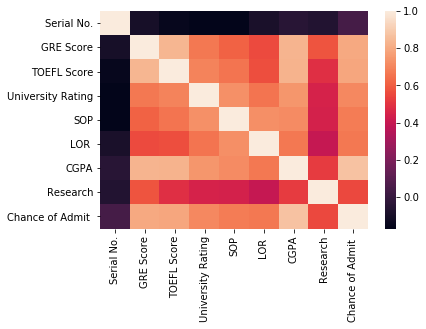

In [35]:
core = data_inicial.corr()
sns.heatmap(core)